<a href="https://colab.research.google.com/github/orlandxrf/curso-dl/blob/main/notebooks/7b_TextCNN_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
# from torchtext import data # no funciiona correctamente
from torchtext.legacy import data
from torchtext.legacy import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import spacy
import time
import matplotlib.pyplot as plt

# cargar el idioma del modelo, en este caso inglés
nlp = spacy.load('en')

# Prepara los datos
Usar `torchtext.legacy` para crear instancias de `data.Field` que servirán preprocesar los conjuntos de datos.<br>
<br>
Para más información ver [data.Field()](https://torchtext.readthedocs.io/en/latest/data.html#torchtext.data.Field)

In [2]:
# Iniciar instancias de clase data.Field con tokenizadores
# utilizar spacy para la tokenización
TEXT = data.Field(tokenize='spacy', batch_first=True, lower=True)
LABEL = data.LabelField(dtype = torch.float)

# cargar el conjunto de datos IMDB de torchtext
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split()

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:07<00:00, 11.1MB/s]


In [3]:
print (f"Train:\t{len(train_data.examples):,}")
print (f"Validation:\t{len(valid_data.examples):,}")
print (f"Test:\t{len(test_data.examples):,}")

print (f"\nTag:\t{test_data.examples[0].label}")
print (f"Review:\t{test_data.examples[0].text}")

Train:	17,500
Validation:	7,500
Test:	25,000

Tag:	pos
Review:	['i', 'rarely', 'watch', 'short', 'films', 'as', 'they', 'only', 'seem', 'to', 'be', 'on', 'late', 'night', 'television', 'and', 'are', 'not', 'publicised', 'enough', 'for', 'me', 'to', 'know', 'which', 'short', 'films', 'are', 'worth', 'while', '.', 'as', 'the', 'room', 'is', 'an', 'extra', 'feature', 'on', 'the', 'hitcher', 'dvd', ',', 'it', 'gave', 'me', 'a', 'wonderful', 'opportunity', 'to', 'witness', 'a', 'high', 'quality', 'short', 'with', 'rutger', 'hauer', 'in', 'excellent', 'form.<br', '/><br', '/>artistically', 'shot', 'in', 'black', 'and', 'white', ',', 'the', 'room', 'explores', 'a', 'man', "'s", 'obsession', 'with', 'a', 'room', 'he', 'passed', 'by', 'in', 'the', 'early', 'stages', 'of', 'adulthood', 'and', 'is', 'expressed', 'in', 'a', 'documentary/', 'interview', 'style', '.', 'the', 'dialogue', 'is', 'very', 'poetic', ',', 'typical', 'of', 'a', 'man', 'expressing', 'his', 'feelings', 'for', 'a', 'woman', ',

### Descargar, utilizar embeddings y Construir vocabularios

In [4]:
# seleccionar las 30,000 palabras más importantes del vocabulario
MAX_VOCAB_SIZE = 30000

# construir vocabaulario
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 # descargar y cargar embeddings pre-entredados
                 vectors = 'glove.6B.100d', # glove.6B.50d
                 # definir los pesos para las palabras no encontradas en los embeddings con: un tensor de números aleatorios extraídos de distribuciones normales
                 unk_init = torch.Tensor.normal_)

# construir el vocabulario de clases o etiquetas
LABEL.build_vocab(train_data)



.vector_cache/glove.6B.zip: 862MB [02:42, 5.30MB/s]                           
100%|█████████▉| 399999/400000 [00:21<00:00, 18182.17it/s]


In [5]:
print (f"Palabras Frecuentes: {TEXT.vocab.freqs}")

Palabras Frecuentes: Counter({'the': 230766, ',': 193863, '.': 166001, 'and': 114805, 'a': 113781, 'of': 102038, 'to': 94928, 'is': 76959, 'it': 65499, 'in': 65269, 'i': 57824, 'this': 51357, 'that': 51063, '"': 44837, "'s": 43737, '-': 37172, '/><br': 35857, 'was': 35022, 'as': 32654, 'with': 30895, 'for': 30749, 'movie': 30020, 'but': 29332, 'film': 27429, 'you': 23826, 'on': 23734, '(': 23427, ')': 23283, "n't": 23113, 'not': 21849, 'he': 21253, 'are': 21219, 'his': 20687, 'have': 19934, 'be': 18892, 'one': 18388, 'at': 16428, 'all': 16418, 'they': 15844, '!': 15826, 'by': 15712, 'who': 15052, 'an': 15017, 'from': 14143, 'like': 14084, 'so': 13965, 'her': 12875, 'or': 12345, 'just': 12289, 'there': 12227, 'do': 12135, 'has': 12060, 'about': 12038, "'": 12028, 'out': 11833, 'if': 10998, 'what': 10963, 'some': 10766, 'good': 10432, '?': 10363, 'she': 10149, 'more': 9859, 'when': 9799, 'very': 9738, 'would': 9557, 'up': 9215, 'no': 8810, 'even': 8617, 'time': 8592, 'can': 8533, 'which'

In [6]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print (f'hardware:\t{device}')

# crear iteradores para los tres conjuntos de datos
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
  (train_data, valid_data, test_data), 
  batch_size = BATCH_SIZE, 
  device = device)

hardware:	cuda


## Definir el modelo 

In [7]:
class CNN_Text(nn.Module):
    ''' Define network architecture and forward path. '''
    def __init__(self, vocab_size, 
                 vector_size, n_filters, 
                 filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        # crear embeddings de palabras a partir de las palabras de entrada
        self.embedding = nn.Embedding(vocab_size, vector_size, padding_idx=pad_idx)
        
        # especificar convoluciones con filtros de diferentes tamaños
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, vector_size)) 
                                    for fs in filter_sizes])
        
        # agregar una capa completamente conectada para predicciones finales
        self.linear = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        # definir Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text):       
        # obtener los embeddings de palabras
        embedded = self.embedding(text).unsqueeze(1)
        
        # realizar convoluciones y aplicar funciones de activación
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        # aplicar max pooling para reducir la dimensionalidad
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        # concatenar poolings y aplicar Dropout
        cat = self.dropout(torch.cat(pooled, dim = 1))

        # capa de salida totalemente conectada
        return self.linear(cat)

## Inicializar datos para el modelo

In [8]:
# longitud del vocabulario
INPUT_DIM = len(TEXT.vocab)
print (f"Longitud del vocabulario:\t{INPUT_DIM:,}")

# tamaño del vector de embeddings seleccionado
EMBEDDING_DIM = 100

# número de filtros
N_FILTERS = 100

# "n-gramas" para ser analizados usando filtros
FILTER_SIZES = [1, 2, 3, 4, 5] # kerneles

# salida de la capa lineal (densa)
OUTPUT_DIM = 1

# probabilidad del Dropout
DROPOUT = 0.5

Longitud del vocabulario:	30,002


In [9]:
# definir la cadena 'UNK'
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

# definir la cadena "<pad>"
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# inicializar el modelo
model = CNN_Text(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

# cargar los embeddings pre-entrenados de GloVe
model.embedding.weight.data.copy_(TEXT.vocab.vectors)

# definir en cero a los pesos iniciales de las palabras desconocidas (UNK) y aquellas para rellenar (PAD)
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

model = model.to(device)

print (model)

CNN_Text(
  (embedding): Embedding(30002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(1, 100, kernel_size=(1, 100), stride=(1,))
    (1): Conv1d(1, 100, kernel_size=(2, 100), stride=(1,))
    (2): Conv1d(1, 100, kernel_size=(3, 100), stride=(1,))
    (3): Conv1d(1, 100, kernel_size=(4, 100), stride=(1,))
    (4): Conv1d(1, 100, kernel_size=(5, 100), stride=(1,))
  )
  (linear): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Definir funciones para entrenamiento

In [10]:
# definir funciones para utilizar en el entrenamiento y evaluación
def accuracy(preds, y):
    """Retorna el accuracy por batch"""
    correct = (torch.round(torch.sigmoid(preds)) == y).float() 
    return correct.sum() / len(correct)

def epoch_time(start_time, end_time):
    """Obtener el tiempo en minutos y segundos"""
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [11]:
# función del entrenamieto
def train(model, iterator, optimizer, loss_function):
    """
    Entrenar el modelo, recibe el conjunto de datos (iterator), optimizador, y la función de pérdida
    Retorna el loss y el accuracy
    """
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        # restablecer el gradiente
        optimizer.zero_grad()
        
        # obtener las predicciones del batch en proceso
        predictions = model(batch.text).squeeze(1)
        
        # obtener la pérdida 
        loss = loss_function(predictions, batch.label)
        
        # calcular el accuracy
        acc = accuracy(predictions, batch.label)
        
        # Backpropagation
        loss.backward()
        
        # Actualizar (optimizar) los pesos
        optimizer.step()
        
        # Almacenar loss y accuracy
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, loss_function):
    """
    Evaluar el conjunto de validación y/o el conjunto de prueba
    Retorna el loss y accuracy
    """
    epoch_loss = 0
    epoch_acc = 0
    
    # indicar la evaluación del modelo
    model.eval()
    
    # No utilizar cálculos del gradiente
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = loss_function(predictions, batch.label)
            
            acc = accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Entrenamiento

In [12]:
# definir optimizador
optimizer = optim.Adam(model.parameters())

# definir la función de perdida
loss_function = nn.BCEWithLogitsLoss()

# instanciar el modelo y el hardware a utilizar
model = model.to(device)

# 
loss_function = loss_function.to(device)

In [13]:
# entrenamiento
N_EPOCHS = 5
# float('inf') actúa como un valor superior ilimitado para la comparación.
# esto es útil para encontrar los valores más bajos para algo
best_valid_loss = float('inf')
val_loss = []
val_acc = []
tr_loss = []
tr_acc = []

for epoch in range(N_EPOCHS):
    
    # calcular el tiempo que tarda cada epoca
    start_time = time.time() # inicializar
    
    # obtener el loss del conjunto de entrenamiento
    train_loss, train_acc = train(model, train_iterator, optimizer, loss_function)

    # obtener el loss del conjunto de validación
    valid_loss, valid_acc = evaluate(model, valid_iterator, loss_function)
    
    end_time = time.time() # obtener el tiempo final
    # obtener los minutos y segundos del tiempo de ejecución
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Almacenar las metricas del entrenamiento
    val_loss.append(valid_loss)
    val_acc.append(valid_acc)
    tr_loss.append(train_loss)
    tr_acc.append(train_acc)
    
    if valid_loss < best_valid_loss: # guardar el mejor modelo
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'CNN-model.pt')
    
    print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch:  1 | Epoch Time: 6m 55s
	Train Loss: 0.555 | Train Acc: 69.48%
	 Val. Loss: 0.379 |  Val. Acc: 83.52%
Epoch:  2 | Epoch Time: 6m 47s
	Train Loss: 0.323 | Train Acc: 86.27%
	 Val. Loss: 0.288 |  Val. Acc: 87.55%
Epoch:  3 | Epoch Time: 6m 49s
	Train Loss: 0.230 | Train Acc: 90.84%
	 Val. Loss: 0.284 |  Val. Acc: 88.14%
Epoch:  4 | Epoch Time: 6m 50s
	Train Loss: 0.158 | Train Acc: 94.03%
	 Val. Loss: 0.258 |  Val. Acc: 89.32%
Epoch:  5 | Epoch Time: 6m 46s
	Train Loss: 0.098 | Train Acc: 96.74%
	 Val. Loss: 0.302 |  Val. Acc: 88.30%


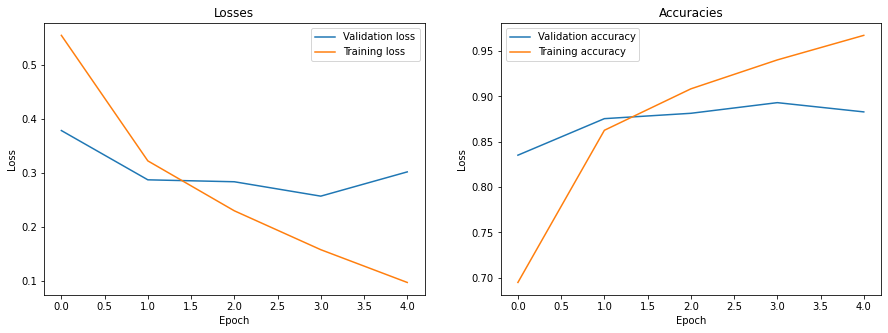

In [14]:
# Graficar accuracy y loss
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(val_loss, label='Validation loss')
ax[0].plot(tr_loss, label='Training loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(val_acc, label='Validation accuracy')
ax[1].plot(tr_acc, label='Training accuracy')
ax[1].set_title('Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.legend()
plt.show()

### Pruebas
con batch size = 64
Con embeddings de longitud 50: Test Loss: 0.333 | Test Acc: 86.00%<br>
Overfitting en el epoch 2 o 3<br>
<br>
Con batch de 128, embeddings=100
Test Loss: 0.331 | Test Acc: 85.88%<br>
<br>
Con batch=64, embeddings=100,<br>
Test Loss: 0.311 | Test Acc: 86.71%<br>
<br>

In [15]:
# Evaluar el modelo con el conjunto de prueba (test)
model.load_state_dict(torch.load('CNN-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, loss_function)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.286 | Test Acc: 88.21%
